#Working with the ADNI PatData data and creating a Random Forest model for predicting Alzheimer's status.

# 1) Opening the file location and loading libraries
Importing all necessary libraries to create our models



In [1]:
# Data cleaning and wrangling packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

# Machine learning model building packages and evaluating their performance
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# Plots and graphs packages
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns

# packages to save your work in google colab
from google.colab import files

Here you will read in data from a file called PatData.csv. I (Pleuni Pennings) created that file as a summary of a larger file called "TADPOLE_D1_D2.csv." This has electronic health record data for every patient and this dataset contains all the variables mentioned in our course text plus the other ones and it is measured across several timepoint. **PatData.csv** is a summary, with just one time point per patient and this is the dataset we will be working on in notebook.

In [2]:
url = "https://raw.githubusercontent.com/pleunipennings/CSC508Data/main/PatData.csv"
data = pd.read_csv(url)

# 2) Having a first look at the data

As usual we should get into the practice of taking a look at how your data is structured, what is the dimention of our data, which variables are our features and which is a label. For the purpose of this notebook, it is important for us to check what variables we would need to one-hot encode.

In [3]:
# Checking how big is our data
data.shape

(1737, 16)

In [4]:
# Looking at each of the variables column names
data.columns

Index(['PTID', 'AGE', 'PTGENDER', 'PTEDUCAT', 'PTETHCAT', 'PTRACCAT',
       'PTMARRY', 'APOE4', 'DX', 'Ventricles', 'Hippocampus', 'WholeBrain',
       'Entorhinal', 'Fusiform', 'MidTemp', 'ICV'],
      dtype='object')

In [5]:
# Checking a couple of rows of our data to see what each column data contains
data.head()


,PTID,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,APOE4,DX,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,MidTemp,ICV
0,002_S_0295,84.8,Male,18,Not Hisp/Latino,White,Married,1.0,NL,43332.500000,6805.125000,1.071568e+06,3752.625000,17693.875000,19420.125000,1.649602e+06
1,002_S_0413,76.3,Female,16,Not Hisp/Latino,White,Married,0.0,NL,31936.454545,6824.636364,1.055413e+06,4131.090909,20095.909091,20235.545455,1.600009e+06
2,002_S_0559,79.3,Male,16,Not Hisp/Latino,White,Widowed,1.0,NL,38410.666667,7496.666667,1.092807e+06,3998.333333,18993.000000,22226.000000,1.703968e+06
3,002_S_0619,77.5,Male,12,Not Hisp/Latino,White,Married,2.0,Dementia,120529.500000,5812.000000,1.093932e+06,2773.000000,20675.000000,19959.000000,2.070530e+06
4,002_S_0685,89.6,Female,16,Not Hisp/Latino,White,Married,0.0,NL,40921.571429,7063.250000,9.800458e+05,3894.375000,14152.250000,18133.625000,1.521331e+06


##Task 1: looking at the data

a. Each row has data for one patient. How many patients are there in the dataset?

Answer: 1479

b. We are looking at a dataset with just one time point per patient. Why do you
think it is useful for an Alzheimer's study to have multiple time points per patient?

Answer: Multiple time points per patient are useful for tracking disease progression, assessing treatment effects, identifying risk factors, and capturing individual variability.

c. Which of the columns do you think would be important for predicting who has Alzheimer's disease? Pick 2 and explain your choice.

Answer: Age and Cognitive Assessment Scores.

d. Which of the columns do you think are not important? Pick 2 and explain.

Answer: I think PTID and PTGENDER are less important. It's less important for predicting Alzheimer's disease because it serves as a unique identifier and including it as a feature can lead to overfitting. PTGENDER (gender) is often considered less important because its impact on Alzheimer's risk is typically not as significant as other factors like age or cognitive assessment scores.

In [6]:
data['PTID'].nunique()

1737

# 3) Data Cleaning: dealing with missing data
Now we have the data, but it is messy, with some missing data. Let's see what columns contain missing data.

In [7]:
# This provides counts of missing values for each column
data.isnull().sum()

PTID            0
AGE             0
PTGENDER        0
PTEDUCAT        0
PTETHCAT        0
PTRACCAT        0
PTMARRY         0
APOE4          12
DX              7
Ventricles     23
Hippocampus    56
WholeBrain     14
Entorhinal     98
Fusiform       98
MidTemp        98
ICV             2
dtype: int64

OK, so first of all, let's just focus on patients that have a diagnosis in DX, since this is our target variable or label.
Using the dropna() function from pandas https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html

In [8]:
# this drops all columns that have missing values in the DX column
data = data.dropna(subset=['DX'])
# Here we will check again all missing values
data.isnull().sum()

PTID            0
AGE             0
PTGENDER        0
PTEDUCAT        0
PTETHCAT        0
PTRACCAT        0
PTMARRY         0
APOE4           6
DX              0
Ventricles     21
Hippocampus    53
WholeBrain     12
Entorhinal     96
Fusiform       96
MidTemp        96
ICV             1
dtype: int64

Check how much data we have left after deleting all the rows without DX information. This information should be given to you by looking at the first element of the shape tuple.

In [9]:
# Checking remaining data
data.shape

(1730, 16)

And let's look at what diagnoses, column "DX" we have, As you can see below We have several diagnoses for the degree of cognitive impairment that range from: **Cognitively Normal** to **Dementia (aka. Alzheimer's Disease)**:

|Diagnosis|Meaning|
|---|---|
|NL|Cognitively normal|
|NL to MCI|Person in between Normal and Mild Cognitive Impairment|
|MCI|Mild Cognitive Impairment|
|MCI to Dementia|Person in between MCI and Alzheimer's Disease|
|Dementia|Person that has Alzheimer's Disease|


In [10]:
# get value counts for all diagnoses
data['DX'].value_counts()

MCI                586
Dementia           577
NL                 423
MCI to Dementia    108
NL to MCI           29
NL to Dementia       3
MCI to NL            3
Dementia to MCI      1
Name: DX, dtype: int64

**NOTE:** We should have only 5 diagnosis in total, yet our count shows 8 total diagnosis! This is because real data comes in really messy. Notice for example that we have **NL to Dementia**, this would be the whole spectrum! so clearly this could be the result of an error during data input.

Therefore, I would like to take out all the in between diagnosis and keep only the main ones: NL, MCI and Dementia. This way we can work with a simpler classification.

In [11]:
# creates an index with the exeptions we have stipulated
index_to_drop = data[ (data['DX'] != "MCI") & (data['DX'] != "NL") & (data['DX'] != "Dementia")].index
# drops all data based on our index
data = data.drop(index_to_drop)


In [12]:
# this should be the new classification scheme
data['DX'].value_counts()

MCI         586
Dementia    577
NL          423
Name: DX, dtype: int64

What's the status of missing data now in the other columns?

In [13]:
# checking missing data again
data.isnull().sum()

PTID            0
AGE             0
PTGENDER        0
PTEDUCAT        0
PTETHCAT        0
PTRACCAT        0
PTMARRY         0
APOE4           6
DX              0
Ventricles     20
Hippocampus    50
WholeBrain     12
Entorhinal     92
Fusiform       92
MidTemp        92
ICV             1
dtype: int64

Because we still have a lot of rows of data, we can go ahead and drop all the remaining columns with missing data

In [14]:
# remove all rows that contain missing data
data = data.dropna()
# Checking our final dataframe
data.shape

(1479, 16)

OK, so we have 1479 patients with complete data now. We will then check the total number of patients per diagnosis. This is important later on when we train our data with our ML models because we want the number for each diagnosis to be roughly similar, that is as close as possible to a **Balanced** Dataset. When this is not the case, it can present problems in terms of trusting our accuracy results blindly. More about this in **Module 6** and **Module 7**

In [15]:
# Checking the total number of patients per diagnosis
data['DX'].value_counts()

MCI         559
Dementia    522
NL          398
Name: DX, dtype: int64

As we can see they are not perfectly equal for all diagnosis but they are close enought that we can proceed.

# Task 2: describing what we did with missing data

In the previous lines of code, we threw out many patients because we didn't have the info we wanted for them. Write a short paragraph where you explain to a potential reader what the number of patients is in the original dataset, which patients we removed for what reason and how many were left for the analysis. Feel free to change the order of operations. For example, I removed first the patients with no diagnosis and later the patients with any missing data. If you do the latter first, you don't have to specifically remove patients with no diagnosis anymore.

Answer: The dataset originally had 1479 patients. We started by removing patients who lacked diagnosis information, which resulted in a different amount. Following that, any remaining patients with missing data in other columns were discarded, leaving us with a final cohort of patients who had both complete diagnosis information and data, assuring data integrity and reliability in our research.

# 4) Data wrangling in preparation for Model training

## - Ensuring feature columns are correct
In this section we will be splitting the data into label (the DX columns) and features (All other columns)



In [16]:
# Split the data in labels and features
labels = data["DX"]
features = data.drop(columns=['DX'])

What do the features look like again? Make sure it doesn't include any columns that will not help in our prediction

In [17]:
# checking features again
features.head()

,PTID,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,APOE4,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,MidTemp,ICV
0,002_S_0295,84.8,Male,18,Not Hisp/Latino,White,Married,1.0,43332.500000,6805.125000,1.071568e+06,3752.625000,17693.875000,19420.125000,1.649602e+06
1,002_S_0413,76.3,Female,16,Not Hisp/Latino,White,Married,0.0,31936.454545,6824.636364,1.055413e+06,4131.090909,20095.909091,20235.545455,1.600009e+06
2,002_S_0559,79.3,Male,16,Not Hisp/Latino,White,Widowed,1.0,38410.666667,7496.666667,1.092807e+06,3998.333333,18993.000000,22226.000000,1.703968e+06
3,002_S_0619,77.5,Male,12,Not Hisp/Latino,White,Married,2.0,120529.500000,5812.000000,1.093932e+06,2773.000000,20675.000000,19959.000000,2.070530e+06
4,002_S_0685,89.6,Female,16,Not Hisp/Latino,White,Married,0.0,40921.571429,7063.250000,9.800458e+05,3894.375000,14152.250000,18133.625000,1.521331e+06


Let's remove PTID (patient ID). We don't need it, since it would not help us predict diagnosis.

In [18]:
# Dropping patient ID column
features = features.drop(columns=['PTID'])

## - One Hot Encoding for categorical variables
Recall from the text that we are unable to work with data that is words in ML models directly, so we need to recode them into numbers. There are languages and algorythms that seem to be able to deal with words, but they are still turning them into numbers under the hood!


In [19]:
# checking the variable types for each column
features.dtypes

AGE            float64
PTGENDER        object
PTEDUCAT         int64
PTETHCAT        object
PTRACCAT        object
PTMARRY         object
APOE4          float64
Ventricles     float64
Hippocampus    float64
WholeBrain     float64
Entorhinal     float64
Fusiform       float64
MidTemp        float64
ICV            float64
dtype: object

As we can see in the output above. There are a few features that are not numerical. We need to make sure that **gender**, **ethnicity** , **race** and **marital status** are coded as numbers. To do this we will need to **one-hot-encode** them. Once we are done doing our one hot encoding, we should see each of the levels of our categorical variables as a recoded column.

In [20]:
# getting a list of categorical variables we need to recode
features_to_encode = list(features.select_dtypes(include = ['object']).columns)
features_to_encode

['PTGENDER', 'PTETHCAT', 'PTRACCAT', 'PTMARRY']

In [21]:
# using a for loop to one-hot encode each of the categorical variables
for f in features_to_encode:
  print("Parent Categorical Variable: ",f)
  z = pd.get_dummies(features[f], prefix=f) #get_dummies is the pandas function for one-hot-encoding
  features = features.join(z) #append new columns
  features = features.drop(columns=[f]) # remove original not recoded column

features.head()

Parent Categorical Variable:  PTGENDER
Parent Categorical Variable:  PTETHCAT
Parent Categorical Variable:  PTRACCAT
Parent Categorical Variable:  PTMARRY


,AGE,PTEDUCAT,APOE4,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,MidTemp,ICV,...,PTRACCAT_Black,PTRACCAT_Hawaiian/Other PI,PTRACCAT_More than one,PTRACCAT_Unknown,PTRACCAT_White,PTMARRY_Divorced,PTMARRY_Married,PTMARRY_Never married,PTMARRY_Unknown,PTMARRY_Widowed
0,84.8,18,1.0,43332.500000,6805.125000,1.071568e+06,3752.625000,17693.875000,19420.125000,1.649602e+06,...,0,0,0,0,1,0,1,0,0,0
1,76.3,16,0.0,31936.454545,6824.636364,1.055413e+06,4131.090909,20095.909091,20235.545455,1.600009e+06,...,0,0,0,0,1,0,1,0,0,0
2,79.3,16,1.0,38410.666667,7496.666667,1.092807e+06,3998.333333,18993.000000,22226.000000,1.703968e+06,...,0,0,0,0,1,0,0,0,0,1
3,77.5,12,2.0,120529.500000,5812.000000,1.093932e+06,2773.000000,20675.000000,19959.000000,2.070530e+06,...,0,0,0,0,1,0,1,0,0,0
4,89.6,16,0.0,40921.571429,7063.250000,9.800458e+05,3894.375000,14152.250000,18133.625000,1.521331e+06,...,0,0,0,0,1,0,1,0,0,0


## Task 3: Categorical data
What type of Categorical variables are we dealing with in our current dataset? Are they ordered or unordered? how many levels does each category have?



**Answer for question 3**

Answer: we are dealing with categorical variables here and nominal variables are categorical variables without a specific order or ranking among their categories.

Now that we cleaned up the data, it's good to **save the data frame** we now have.

In [22]:
# code to save our current dataframe as a csv file
features.to_csv('PatData_cleaned_one_hot_encoded.csv', index=False)
# code to download our csv file into your own computer
files.download('PatData_cleaned_one_hot_encoded.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Random Forest with one-Hot Encoded Data

Similar to previous modules we can go ahead and prepare our data for training a Random Forest.

In [23]:
# Separating data into training and testing
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.3, random_state=42) # 70% training and 30% test

# Creating Random Forest object
rf = RandomForestClassifier(n_estimators = 100, max_features = "auto", bootstrap = True, random_state = 42)

# Training your Random Forest
rf.fit(features_train, labels_train)

#Predict the response for test dataset
labels_pred = rf.predict(features_test)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Let's take a peak at how our model has performed at least for the first 10 patients of our testing data.

In [24]:
# Look at the predicted values.
print(labels_pred[:10])
# And the real values.
print(labels_test.to_numpy(dtype=object)[:10])
#See how many correct predictions there are among the first 10 patients.

['Dementia' 'MCI' 'NL' 'Dementia' 'NL' 'Dementia' 'NL' 'MCI' 'NL' 'MCI']
['Dementia' 'MCI' 'NL' 'Dementia' 'MCI' 'Dementia' 'NL' 'MCI' 'MCI' 'MCI']


[[131  36   6]
 [ 25  92  41]
 [  5  46  62]]


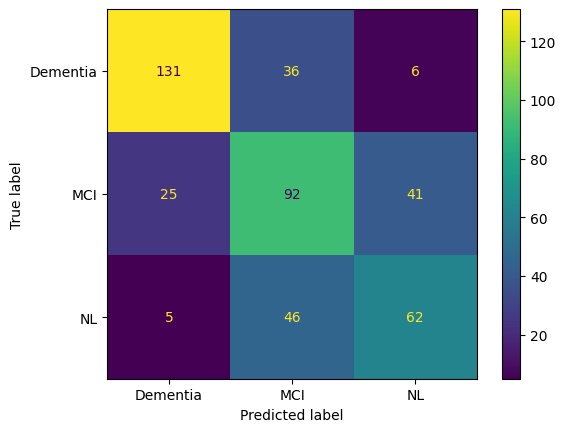

In [25]:
# Showing the confusin matrix for our Decision tree results
print(metrics.confusion_matrix(labels_test, labels_pred))
plt2 = metrics.ConfusionMatrixDisplay.from_estimator(rf, features_test, labels_test)
plt.grid(False)

Unlike our other Confusion Matrices, this time we have a 3 by 3 matrix. So this time what we want is for the main diagonal to show us the bigger numbers. What do you think? What diagnosis got the best results?

##Task 4: Write what you noticed about the confusion matrix here!

#5) Feature importance

Just like in the heart disease notebook, we will now look at the feature importance for the random forest model.

As a reminder: Visualizing your results is always an important part of any data science project. Now that we have a random forest based on 1000 random trees, we cannot easily visualize all the trees at once like we did for the decision tree, because it would be an overwhelming set of diagrams. But we can visualize the feature importance. I've seen this kind of plot in published articles. I like it because it helps us understand which features are most important for making predictions.

Feature importance is a measurement of how each feature decreases the amount of impurity (Gini index) in a node, weighted by the probability of reaching that node. The higher the value the more important the feature. This is usually calculated for each tree in the random forest and then averaged over the total number of trees. The graph below shows these averages.

In [26]:
# calculating feature importance
importance = rf.feature_importances_

# summarize feature importance
names = features.columns.to_numpy(dtype=object)

# Creating a dataframe
importanceDF = pd.DataFrame({'names':names, 'importance':importance})

<Axes: title={'center': 'Feature importance'}, ylabel='names'>

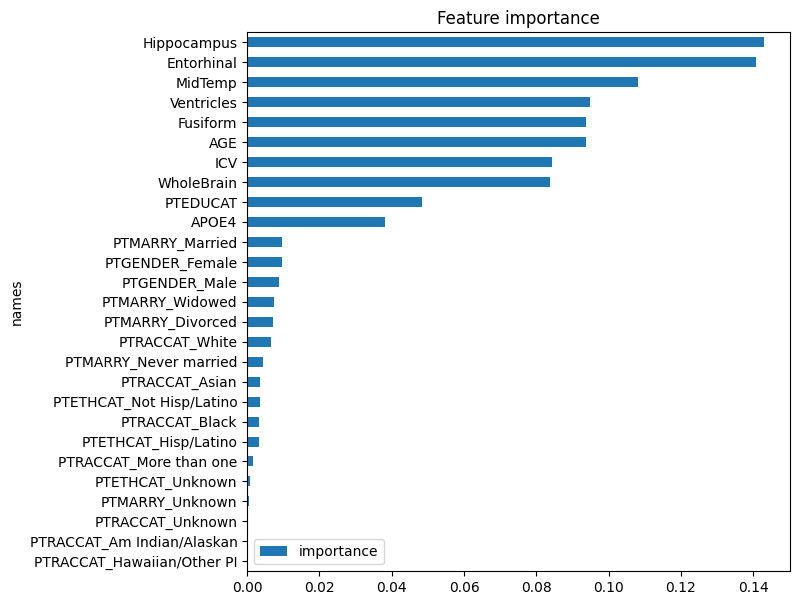

In [27]:
#Sort the dataframe based on importance
importanceDF = importanceDF.sort_values(by=['importance'])

# Plotting feature importance
importanceDF.plot.barh(x='names', y='importance', figsize = (7,7), title = "Feature importance")

## Task 4:

Look at the pandas documentation pages and make at least two changes to the plot (e.g. colors, width, size, legend etc)

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.barh.html

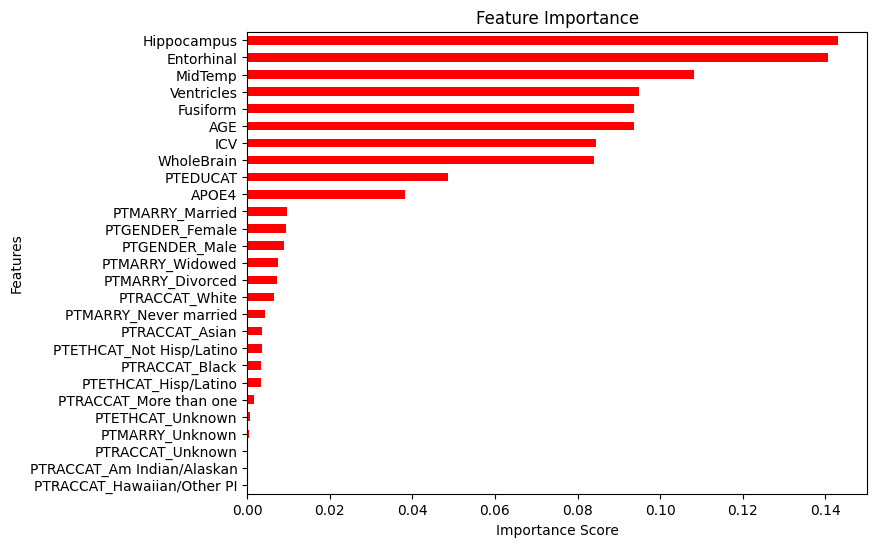

In [28]:
ax = importanceDF.plot.barh(x='names', y='importance', figsize=(8, 6), color='red', legend=False, title="Feature Importance")
ax.set_xlabel("Importance Score")
ax.set_ylabel("Features")
plt.show()



## Task 5: on Accuracy

In addition to a confusion matrix, it is also good to have an accuracy score.

a. From sklearn.metrics import the function accuracy_score.

b. Use the accuracy_score function to calculate the accuracy of the RF model.

c. Once you have stored the accuracy in a variable called accuracy,
you can run print("Accuracy: %.2f%%" % (accuracy * 100)). Alternatively, you can use the "round" function to round off the accuracy to the desired number of decimals.

d. See what happens if you change the 2f into 1f or 3f.

e. What level of accuracy is useful for doctors and patients do you think?

f. Look at the feature importance bar plot. Compare with your predictions from earlier in the notebook. Were you right or wrong in your predictions? Explain.


In [29]:
# Calculate the accuracy using your code!
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(labels_test, labels_pred)
print("Accuracy: %.2f%%" % (accuracy * 100))



Accuracy: 64.19%


In [30]:
print("Accuracy: %.1f%%" % (accuracy * 100))
print("Accuracy: %.3f%%" % (accuracy * 100))

Accuracy: 64.2%
Accuracy: 64.189%


**Answer written question 5 here!**

B: accuracy = accuracy_score(y_true, y_pred)

C: print("Accuracy: %.2f%%" % (accuracy * 100))


D: 2f into 1f will round to one decimal while 3f will round to the 3rd decimal.

E: About 90%

F: By looking at the bar plot, I think my predictions were right because when the accuracy scores are compres, they both are pretty close




# Conclusion of this part
What we can see is that the volumes of the parts of the brain are most important, starting with the hippocampus. Gender, race and ethnicity seem least important out of the features we looked at. For race and ethnicity this may be because the data almost entirely consists of non-hispanic whites.